### 1. Loading the Iris dataset from scikit-learn

#### 1.1 Importing Libraries

In [190]:
# Basic Imports
import numpy as np
import pandas as pd
import math

# Plotting Libraried
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset from skLearn
from sklearn.datasets import load_iris

# Some Processing Functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,precision_recall_curve,auc,average_precision_score,confusion_matrix
from sklearn.model_selection import KFold

#### 1.2 Loading the Dataset

In [191]:
# Loading the dataset
iris = load_iris()
x = iris.data
y = iris.target
df = pd.DataFrame(x, columns=iris.feature_names)
df['target'] = y
print(x.shape)
y_copy = y

(150, 4)


#### 1.3 Checking Missing Values

In [192]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


#### 1.4 Removing the Duplicate Values

In [193]:
# Remove the duplicate rows
df=df.drop_duplicates()
x = df.drop(columns=["target"])
y = df["target"]

### 2. The class distribution of the dataset using a bar graph

#### 2.1 Class Distribution

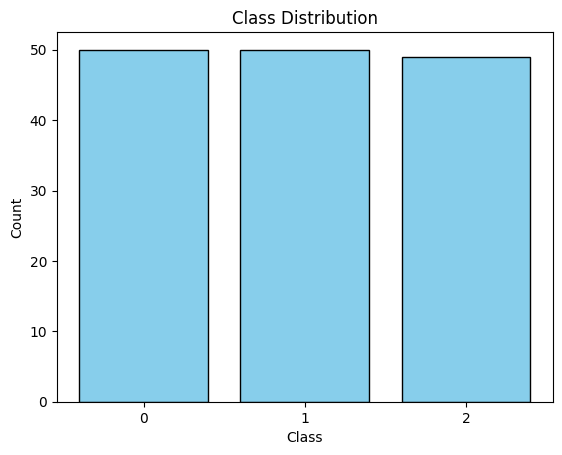

In [194]:
classes, counts = np.unique(y, return_counts=True)

plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

As can be seen from the graph above that the dataset is nearly distributed uniformly in all the three classes.

### 3. Encoding the class labels as one-hot vectors

#### 3.1 Encoding class labels

In [195]:
def OneHotEncoding(y,features):
  res = []
  for val in y:
    temp = []
    for i in features:
      if(val==i):
        temp.append(1)
      else:
        temp.append(0)
    res.append(temp)
  return np.array(res)

features = [0,1,2]
y_copy = y
y = OneHotEncoding(y,features)

### 4. Splitting the data into training, validation, and test sets (70%-15%-15%)

#### 4.1 Spliting the Dataset

In [196]:
# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

### 5. Preprocess the dataset as required, i.e. feature scaling or standardization

#### 5.1 Fitting the scaler with training set

In [197]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

#### 5.2 Scaling the train,test and validation sets

In [198]:
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### 6. Implementing a softmax (multinomial) logistic regression model from scratch.

#### 6.1 Softmax logistic regression

In [ ]:
class Softmax:
  def __init__(self,learning_rate,iterations,reg_lambda):
    self.iterations=iterations
    self.learning_rate=learning_rate
    self.loss_history_train=[]
    self.loss_history_val=[]
    self.probability=[]
    self.reg_lambda = reg_lambda

  def fit(self,x_train,y_train,x_val,y_val):
    m, n = x_train.shape
    k = y_train.shape[1]
    self.theta = np.zeros((n+1, k))

    # Gradient Descent
    for _ in range(self.iterations):
      x_train_b = self.add_intercept(x_train)
      x_val_b = self.add_intercept(x_val)

      predict_train = self.predict(x_train_b)
      # Compute gradients
      errors_train = predict_train - y_train
      gradients = (x_train_b.T.dot(errors_train))/m
      gradients[1:] += (self.reg_lambda/m) * self.theta[1:]

      # Update weights
      self.theta -= self.learning_rate * gradients

      # Compute and store cost for training and validation sets
      cost_train = self.compute_loss(y_train, predict_train)
      self.loss_history_train.append(cost_train)

      predictions_val = self.predict(x_val_b)
      cost_val = self.compute_loss(y_val, predictions_val)
      self.loss_history_val.append(cost_val)


  def predict(self, x):
    z = x.dot(self.theta)
    prob = []
    for r in range(len(z)):
      temp = []
      max_val = np.max(z[r])
      total = 0
      exp_vals = []
      for j in range(len(z[r])):
        e_val = np.exp(z[r][j]-max_val) # To avoid overflow
        exp_vals.append(e_val)
        total += e_val
      temp = [val / total for val in exp_vals]
      prob.append(temp)
    prob = np.array(prob)

    return prob

  def predict_class(self,x_test):
    x_test_b = self.add_intercept(x_test)
    prob = self.predict(x_test_b)
    self.probability = prob
    return np.argmax(prob,axis=1)

  def compute_loss(self,y_true,y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15   # To avoid terms leading to log(0)
    loss = -np.mean(np.sum(y_true * np.log(y_pred+epsilon),axis=1))
    # Adding the regularization loss
    loss += (self.reg_lambda/(2*m))*np.sum(self.theta[1:]**2)
    return loss

  def get_cost_history(self):
    return self.loss_history_train, self.loss_history_val

  def add_intercept(self, X):
    return np.c_[np.ones(X.shape[0]), X]


### 7. Using cross entropy as loss and apply L2 regularization weights in the cost function and training the softmax logistic regression model with gradient descent

#### 7.1 Cross validation to find a suitable value of the learning rate and regularization parameter.

In [200]:
# Different values of learning rates and regularization parameters
learning_rates = [0.001,0.005,0.01,0.05,0.1]
reg_lambdas = [0.0001,0.001,0.01,0.1]
x_train_copy = x_train
y_train_copy = y_train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_loss = float('inf')
best_learning_rate = None
best_reg_lambda = None
for i in learning_rates:
  for j in reg_lambdas:
    val_loss = []

    for train_index, val_index in kf.split(x_train):
      x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
      y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

      softmax = Softmax(learning_rate=i, iterations=1000,reg_lambda=j)
      softmax.fit(x_train_fold, y_train_fold, x_val_fold, y_val_fold)
      val_loss.append(softmax.loss_history_val[-1])
    loss = np.mean(val_loss)
    if loss < best_loss:
      best_loss = loss
      best_learning_rate = i
      best_reg_lambda = j
print("Best Learning Rate: ",best_learning_rate)
print("Best Regularization Lambda: ",best_reg_lambda)
print("Loss with best parameters: ",best_loss)
x_train = x_train_copy
y_train = y_train_copy

Best Learning Rate:  0.1
Best Regularization Lambda:  0.0001
Loss with best parameters:  0.1536842913470075


#### 7.2 Training and validation loss vs. training epochs plot.

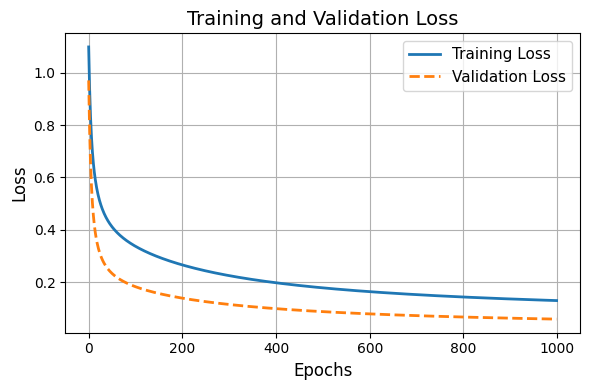

In [201]:
softmax = Softmax(learning_rate=best_learning_rate, iterations=1000,reg_lambda=best_reg_lambda)
softmax.fit(x_train, y_train, x_val, y_val)
# Plot training and validation loss
plt.figure(figsize=(6, 4))  # Slightly larger for better spacing

plt.plot(softmax.get_cost_history()[0], label='Training Loss', linewidth=2)
plt.plot(softmax.get_cost_history()[1], label='Validation Loss', linestyle='--', linewidth=2)

# Set axis labels and title with font sizes
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)

# Tick label sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Legend with font size
plt.legend(fontsize=11)

# Improve layout
plt.tight_layout()
plt.grid(True)
plt.show()

### 8. The prediction performance of the implementation on the test set in terms of confusion matrix, precision, recall and area under precision recall curve

#### 8.1 Training the model

In [202]:
softmax = Softmax(learning_rate=best_learning_rate, iterations=1000,reg_lambda=best_reg_lambda)
softmax.fit(x_train, y_train, x_val, y_val)

#### 8.2 Prediction performance of the model

In [203]:
y_pred1 = softmax.predict_class(x_test)
y_test_labels = np.argmax(y_test,axis=1)

accuracy = accuracy_score(y_test_labels, y_pred1)
print(f"Accuracy: {accuracy:.6f}")

precision = precision_score(y_test_labels, y_pred1, average='weighted')
print(f"Precision: {precision:.6f}")

recall = recall_score(y_test_labels, y_pred1, average='weighted')
print(f"Recall: {recall:.6f}")

y_pred_prob1 = softmax.probability
area = average_precision_score(y_test, y_pred_prob1, average='weighted')
print(f"Area under PR curve: {area:.6f}")

con_matrix = confusion_matrix(y_test_labels, y_pred1)
print("Confusion Matrix:")
print(con_matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Area under PR curve: 1.000000
Confusion Matrix:
[[ 6  0  0]
 [ 0 10  0]
 [ 0  0  7]]


### 9. Fitting a logistic regression model using scikit-learn's Logistic Regression model

#### 9.1 Splitting the dataset

In [204]:
y = y_copy
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#### 9.2 Scaling the features

In [205]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val   = scaler.transform(x_val)
x_test  = scaler.transform(x_test)

#### 9.3 Training the model

In [206]:
model = LogisticRegression(penalty='l2', C=1/best_reg_lambda)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

### 10. Comparing the performance of the custom logistic regression model with scikit learn in terms of accuracy, precision, recall and area under precision-recall curve.

#### 10.1 Comparing the performance

In [207]:
print("Using scikit-learn's Logistic Regression Model")
accuracy_model = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_model:.6f}")

precision_model = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision_model:.6f}")

recall_model = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall_model:.6f}")

y_pred_prob = model.predict_proba(x_test)
area_model = average_precision_score(y_test, y_pred_prob, average='weighted')
print(f"Area under PR curve: {area_model:.6f}")

print()

print("Using custom Logistic Regression Model")
print(f"Accuracy: {accuracy:.6f}")

print(f"Precision: {precision:.6f}")

print(f"Recall: {recall:.6f}")

print(f"Area under PR curve: {area:.6f}")

Using scikit-learn's Logistic Regression Model
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Area under PR curve: 1.000000

Using custom Logistic Regression Model
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Area under PR curve: 1.000000


The implemented softmax logistics regression model and the scikit-learn's multinomial logistic regression achieved comparable performance acroos all the above evaluated metrics on the given dataset.